In [1]:
# Librerias para la manipulacion y el pre procesamiento de datos
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from collections import Counter
import warnings

warnings.filterwarnings('ignore')


# Algoritmos de clasificacion
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, auc, roc_curve

from sklearn.model_selection import GridSearchCV


plt.style.use ('fivethirtyeight')

Conjunto de datos 

In [2]:
#od.download('https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud', force = True)
data1 = pd.read_csv('./creditcardfraud/creditcard.csv')
data_principal = pd.read_csv('./creditcardfraud/creditcard.csv')
data1.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# Columnas y filas
data1.shape

(284807, 31)

In [4]:
# Columnas presentes en el anaálisis
data1.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [5]:
# Variable respuesta desvalanceada
data1[['Class']].value_counts()

Class
0        284315
1           492
dtype: int64

In [6]:
data1[['Class']].value_counts() / len(data_principal) * 100

Class
0        99.827251
1         0.172749
dtype: float64

Text(0, 0.5, '')

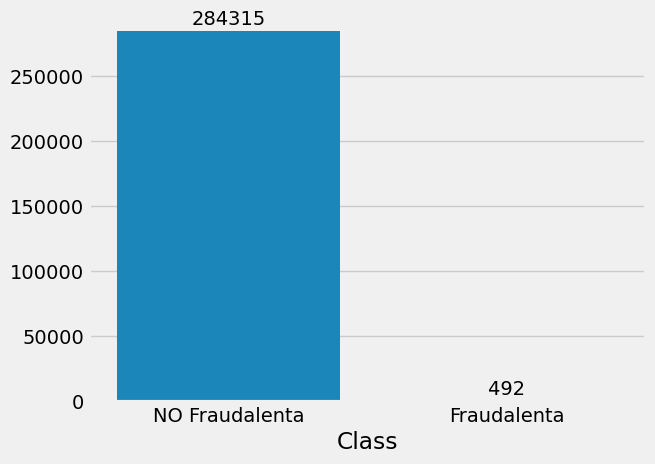

In [7]:
ax = sns.countplot(data = data_principal, x = "Class")

for i in ax.patches:
    ax.text(i.get_x() + i.get_width()/2, 5000 + i.get_height(), f'{int(i.get_height())}', ha = 'center')
    
ax.set_xticklabels(['NO Fraudalenta', 'Fraudalenta'])
ax.set_ylabel('')

In [8]:
# Revision de datos nulos
data1.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [9]:
# Estadisticas descriptivas
data1.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Al haber mucha diferencia entre el valor máximo y mínimo de las variables Time y Amount, se decide realizar una tranformacion antes de aplicar los algoritmos correspondientes, mediate un escalador Robusto evitando usar la media al ser sensible a posibles datos atipicos

In [10]:
# Información general del dataset
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [11]:
# Estadisticas descriptivas para la variable Amount para la Clase 1
data1[data1['Class'] == 1]['Amount'].describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [12]:
# Estadisticas descriptivas para la variable Amount para la Clase 0
data1[data1['Class'] == 0]['Amount'].describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

Las transacciones fraudalentas se hacen de valores pequeños para asi evitar cualquier sobreaviso sobre las transacciones, por esta razóna, el máximo valor con el cual se realizó una transacción fraudalenta es de 2125.87 y un mínimo de 0.

Se deciden no eliminar atipicos debido a que las transacciones fraudalentas serian concideradas atipicos al presentar ciertas caracteristicas en especial, a pesar de que se evitan realizar transferencias grandes

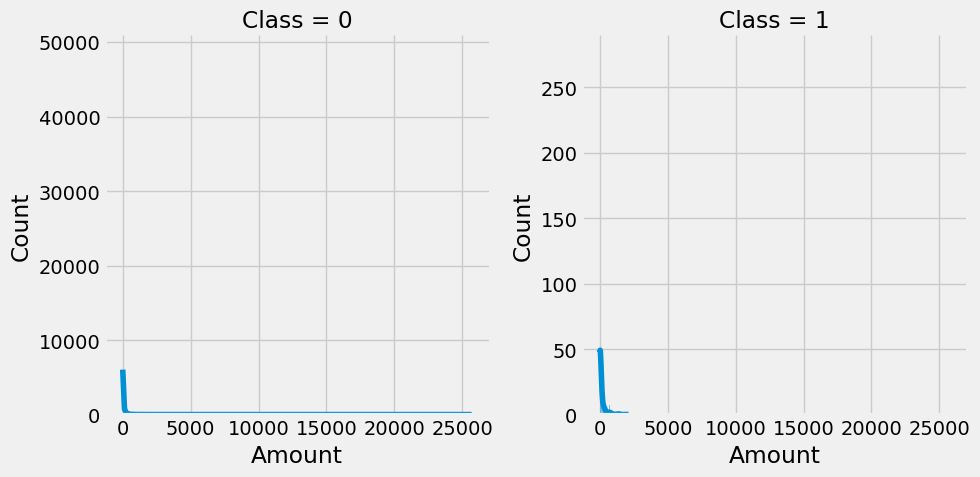

In [13]:
g = sns.FacetGrid(data = data1, col = 'Class', height = 5, sharey = False)
g.map_dataframe(sns.histplot, x = 'Amount', kde = True)
plt.show()

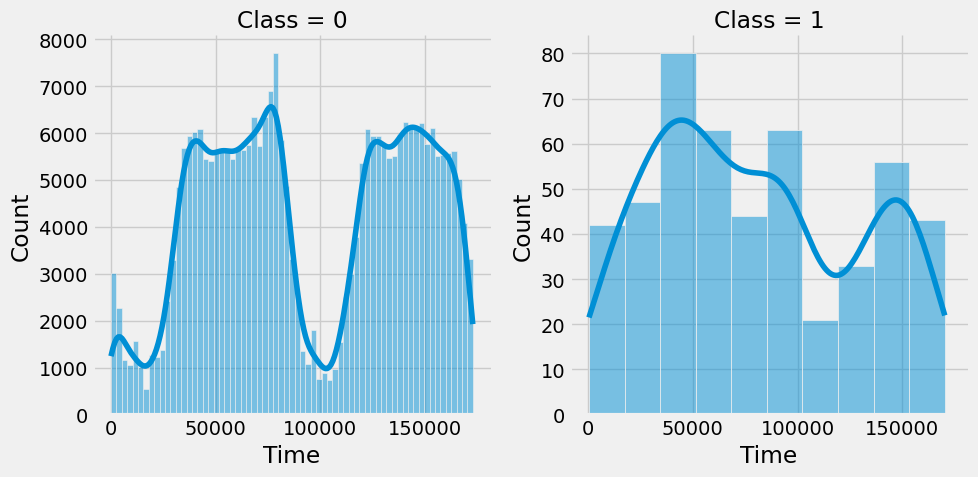

In [14]:
g = sns.FacetGrid(data = data1, col = 'Class', height = 5, sharey = False)
g.map_dataframe(sns.histplot, x = 'Time', kde = True)
plt.show()

In [15]:
# Funciones para facilitar la generacion de modelos

def model_eje(X_train_sint, y_train_sint):
    md = LogisticRegression(penalty  = 'l2', C = 10, random_state = 8, solver = 'newton-cg')
    md.fit(X_train_sint, y_train_sint)
    return md


def resultados_md(y_test, y_pred):
    res_mtx = confusion_matrix(y_test, y_pred)
    plt.figure(figsize = (4, 4))
    sns.heatmap(res_mtx, xticklabels = ['Fraud', 'No Fraud'], yticklabels = ['Fraud', 'No Fraud'], annot = True, fmt ='d')
    plt.title('Matriz de confusión')
    plt.xlabel('Clases test')
    plt.ylabel('Clases estimadas')
    plt.show()
    print(classification_report(y_test, y_pred))
    

In [16]:

# Division en conjunto de entrenamiento y test
X = data1.drop(columns = ['Class'])
y = data1['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .8, random_state = 8)


# Escalado de variables, TIME Y AMOUNT

scaler_rb = RobustScaler()
X_train[['Time', 'Amount']] = scaler_rb.fit_transform(X_train[['Time', 'Amount']])
X_test[['Time', 'Amount']] = scaler_rb.transform(X_test[['Time', 'Amount']])


# Columna transformada antes de eliminar atipicos
# No es necesario solo aumenta los falsos positivos de 685 a 687 si se aplica logaritmos
#X_train[['Time', 'Amount']] = np.log1p(X_train[['Time', 'Amount']])
#X_test[['Time', 'Amount']] = np.log1p(X_test[['Time', 'Amount']])

# eliminacion de datos atipicos
def atipicos_na(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    
    IQR = Q3 - Q1
    
    lim_inf = Q1 - 1.5 * IQR
    lim_sup = Q3 + 1.5 * IQR
    
    return data[(data[col] >= lim_inf) & (data[col] <= lim_sup)], lim_inf, lim_sup


dt_no_fraude = X_train[y_train == 0]
dt_no_fraude, lim_inf, lim_sup = atipicos_na(dt_no_fraude, 'Amount')

# Eliminar atipicos disminuyen las metricas
#X_train = pd.concat([dt_no_fraude, X_train[y_train == 1]])
#y_train = y_train.loc[X_train.index]


# Creacion de muestras sinteticas

smote = SMOTETomek(sampling_strategy = 0.5, random_state = 8)
X_train_sint, y_train_sint = smote.fit_resample(X_train, y_train)


In [17]:
# Ejecucion del modelo
model = model_eje(X_train_sint, y_train_sint)

Encontrar los mejores hiperparametros para el modelo de regresion logistica

In [18]:
paramts = {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'newton-cg'] }
gridCV = GridSearchCV(LogisticRegression(penalty = 'l2', random_state = 8), paramts, cv = 5, scoring = 'f1')
gridCV.fit(X_train_sint, y_train_sint)

gridCV.best_estimator_


LogisticRegression(C=10, random_state=8, solver='liblinear')

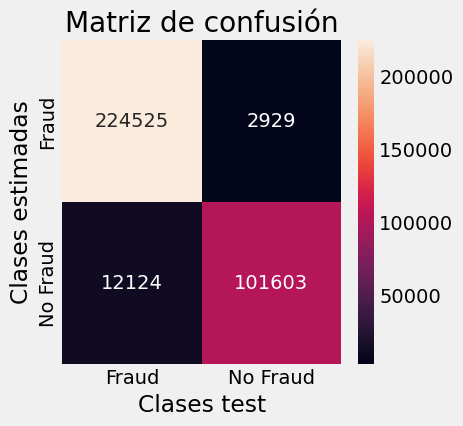

              precision    recall  f1-score   support

           0       0.95      0.99      0.97    227454
           1       0.97      0.89      0.93    113727

    accuracy                           0.96    341181
   macro avg       0.96      0.94      0.95    341181
weighted avg       0.96      0.96      0.96    341181



In [19]:
# Clasificacion del modelo con los datos de entrenamiento
y_pred =  model.predict(X_train_sint)
resultados_md(y_train_sint, y_pred)

La metrica que se requiere mejorar es el Recall o la capacidad del modelo de detectar los casos relevantes o positivos para la clase 1, el modelo con los datos de entrenamiento se obtiene un recall de 0.89, 

In [20]:
# Tamaño de muestras utilizadas en el entrenamiento y la muestra sintetica generada
Counter(y_train), Counter(y_train_sint), Counter(y_pred)

(Counter({0: 227454, 1: 391}),
 Counter({0: 227454, 1: 113727}),
 Counter({0: 236649, 1: 104532}))

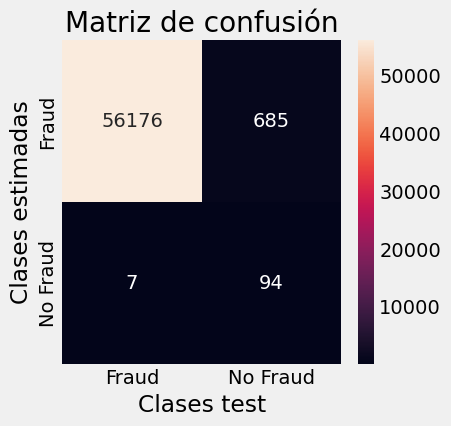

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56861
           1       0.12      0.93      0.21       101

    accuracy                           0.99     56962
   macro avg       0.56      0.96      0.60     56962
weighted avg       1.00      0.99      0.99     56962



In [21]:
# Clasificacion del modelo con los datos de test (datos nuevo)
y_pred = model.predict(X_test)
resultados_md(y_test, y_pred)

Al utilizar nuevos datos, siendo estos los datos de test, se obtiene un recall de 0.93, el modelo es bueno a la hora de detectar cuando una transaccion es fraudalenta

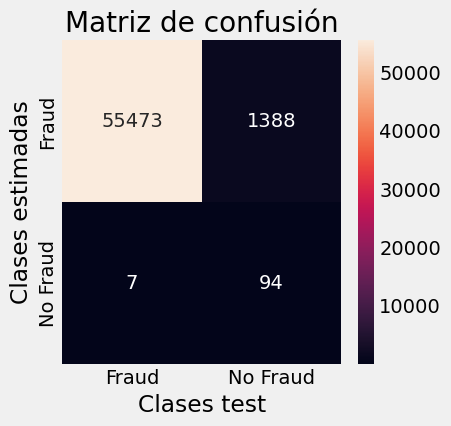

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56861
           1       0.06      0.93      0.12       101

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.98      0.99     56962



In [22]:
# Modelo sin modificacion de datos

md = LogisticRegression(random_state = 8, class_weight = 'balanced')
md.fit(X_train, y_train)

y_pred = md.predict(X_test)

resultados_md(y_test, y_pred)

El objetivo es mejorar la metrica del recall, aplicando un modelo con los datos originales sin la creacion de muestras sinteticas, se obtiene un recall igual al anterior modelo, pero el número de falsos positivos aumentan, por lo cual si es recomendable aplicar las muestras sintéticas.

[Text(0.5, 1.0, 'CURVA ROC-AUC'),
 Text(0.5, 0, 'Tasa falsos positivos'),
 Text(0, 0.5, 'Tasa verdaderos positivos')]

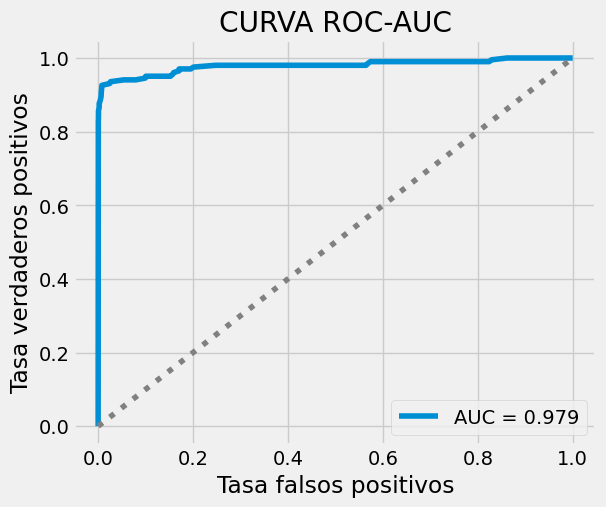

In [23]:
# Curva ROC-AUC modelo LogisticRegression

y_pred_prob = model.predict_proba(X_test)[:, 1]
fp, vp, auxs = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fp, vp)

plt.figure(figsize = (6, 5))

ax = sns.lineplot(x = fp, y = vp, label = f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color = 'gray', linestyle = ':')
ax.set(title = 'CURVA ROC-AUC', xlabel = 'Tasa falsos positivos', ylabel = 'Tasa verdaderos positivos')

Model:  Logistic Regression
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56861
           1       0.12      0.93      0.21       101

    accuracy                           0.99     56962
   macro avg       0.56      0.96      0.60     56962
weighted avg       1.00      0.99      0.99     56962

Model:  Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.89      0.84      0.87       101

    accuracy                           1.00     56962
   macro avg       0.95      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962

[16:18:35] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters 

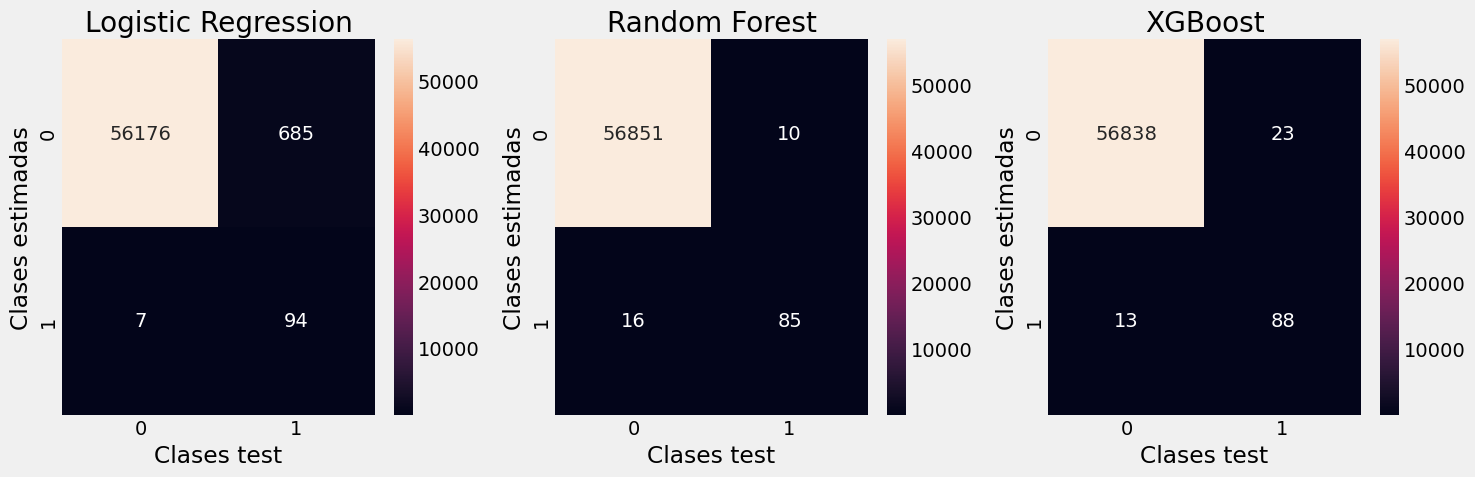

In [24]:
# Comparacion con otros modelos

modelos = {
    "Logistic Regression" : LogisticRegression(penalty  = 'l2', C = 10, random_state = 8, solver = 'newton-cg'),
    "Random Forest" : RandomForestClassifier(),
    "XGBoost" : XGBClassifier(use_label_encoder = False, eval_metric = 'logloss'),
    #"SVM": SVC(probability = True, kernel = 'linear')
    }

n_models = len(modelos)
 
fig, axes = plt.subplots(1, n_models, figsize = (15, 5))
axes = axes.flatten()
i = 0

list_prob = []

for md, model in modelos.items():
    mdl = model.fit(X_train_sint, y_train_sint)
    y_pred = mdl.predict(X_test)
    list_prob.append(mdl.predict_proba(X_test)[:, 1])
    mc = confusion_matrix(y_test, y_pred)
    sns.heatmap(mc, annot = True, fmt = 'd', ax = axes[i])
    
    print('Model: ', md)
    print(classification_report(y_test, y_pred))
    
    axes[i].set(title = md, xlabel = 'Clases test', ylabel = 'Clases estimadas')
    
    i+=1
    
plt.tight_layout()
plt.show()
    
    


[16:24:05] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




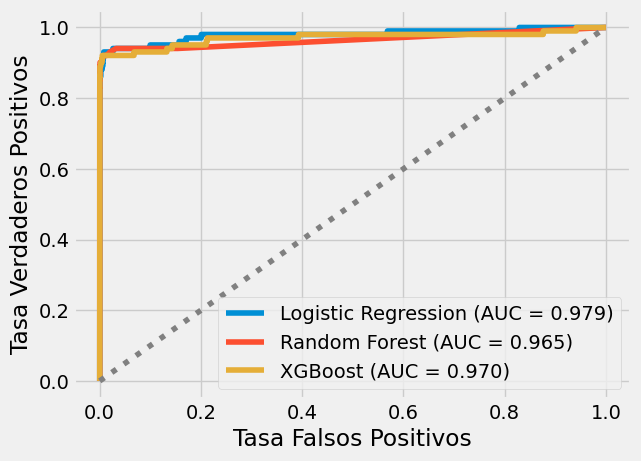

In [25]:
# Curva ROC-AUC para los modelos generados

for md, model in modelos.items():
    model.fit(X_train_sint, y_train_sint)
    y_pred_pb = model.predict_proba(X_test)[:, 1]
    fp, vp, sob = roc_curve(y_test, y_pred_pb)
    auc_c = roc_auc_score(y_test, y_pred_pb)
    plt.plot(fp, vp, label = f"{md} (AUC = {auc_c:.3f})")
    
plt.plot([0, 1], [0, 1], color = 'gray', linestyle = ':')
plt.xlabel('Tasa Falsos Positivos')
plt.ylabel('Tasa Verdaderos Positivos')
plt.legend()
plt.show()

La comparacion entre los modelos de clasificación muestran como mejor al RegressionLogistic con un 0.93 de recall, esto se debe tambien a que es justamente un modelo diseñado para trabajar con problemáticas como estas, es decir, a la clasificación binaria. Se mide la relación de una variable binaria dependiente con una o varias variables independientes. 

<Axes: >

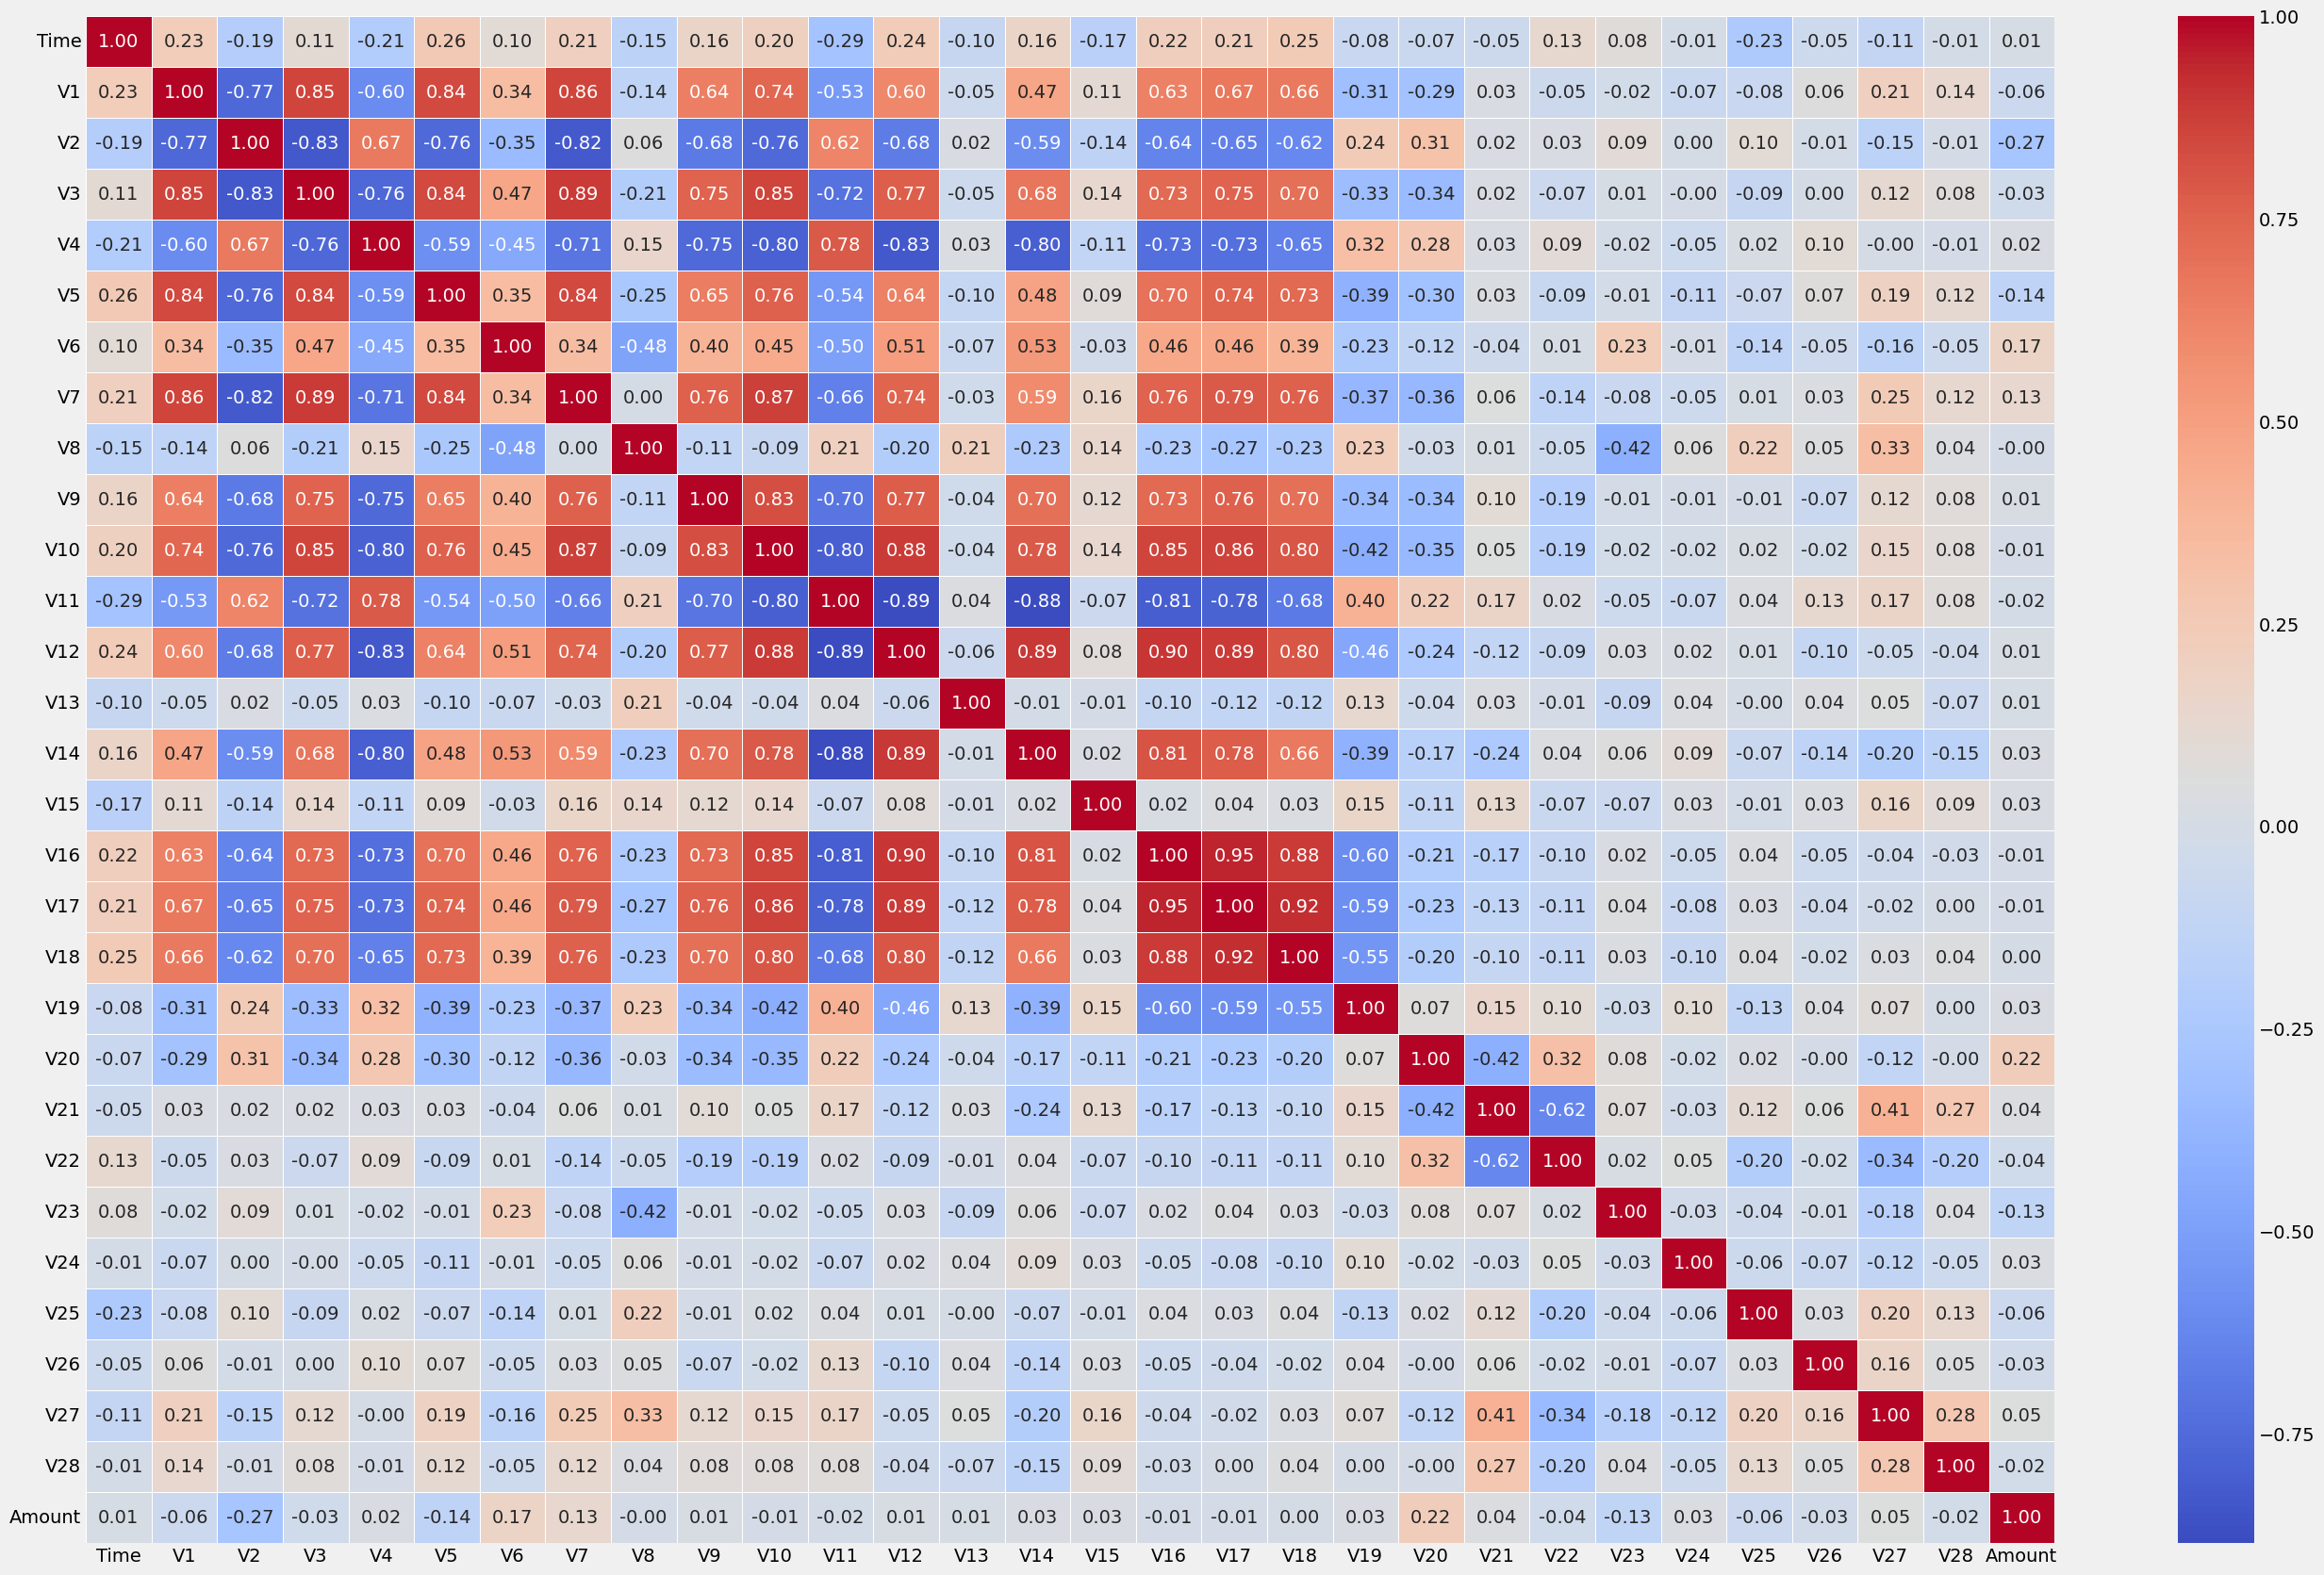

In [26]:
# Matriz de correlacion de las variables sinteticas de entrenamiento

plt.figure(figsize = (30, 20))
sns.heatmap(X_train_sint.corr(), cmap = 'coolwarm', annot = True, fmt = '.2f', linewidths = .5)

In [27]:
# Nuevo modelo con un par de variables con mayor correlacion

model = model_eje(X_train_sint.iloc[:, [16, 17]], y_train_sint)

Representacion gráfica aproximada en dos dimesiones de como se logra la clasificacion de las transacciones fraudalentas, tomando en cuenta dos variables altamente correlacionadas

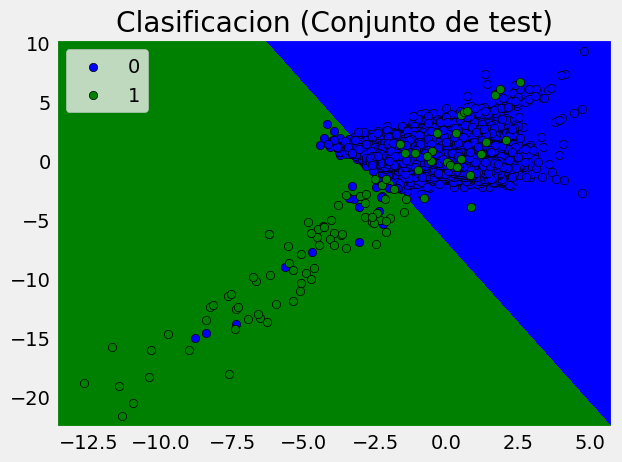

In [28]:
# Conjunto de test
set_X, set_y = X_test, y_test

X1, X2 = np.meshgrid(np.arange(start = set_X.iloc[:, 16].min() - 1, stop = set_X.iloc[:, 16].max() + 1, step = 0.01),
                     np.arange(start = set_X.iloc[:, 17].min() - 1, stop = set_X.iloc[:, 17].max() + 1, step = 0.01))
plt.contourf(X1, X2, model.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape), cmap = ListedColormap(("blue", "green")))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

for i, j in enumerate(np.unique(set_y)):
    plt.scatter(set_X.loc[set_y== j, set_X.columns[16]], set_X.loc[set_y == j, set_X.columns[17]], c = ListedColormap(("blue", "green"))(i), label = j,
               edgecolor = "black")

plt.title("Clasificacion (Conjunto de test)")
plt.legend()
plt.show()

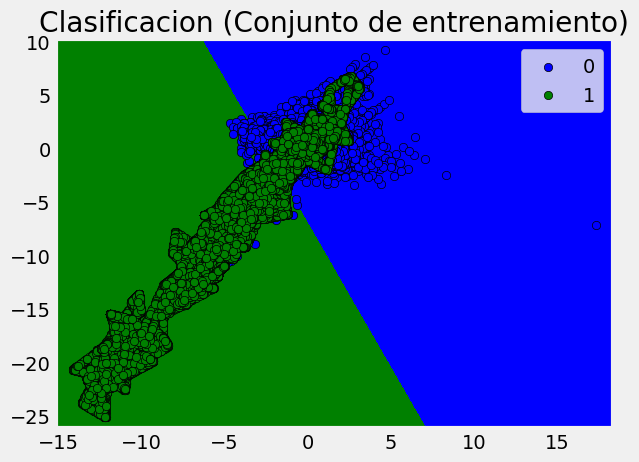

In [29]:
# Conjunto de entrenamiento
set_X, set_y = X_train_sint, y_train_sint

X1, X2 = np.meshgrid(np.arange(start = set_X.iloc[:, 16].min() - 1, stop = set_X.iloc[:, 16].max() + 1, step = 0.01),
                     np.arange(start = set_X.iloc[:, 17].min() - 1, stop = set_X.iloc[:, 17].max() + 1, step = 0.01))
plt.contourf(X1, X2, model.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape), cmap = ListedColormap(("blue", "green")))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

for i, j in enumerate(np.unique(set_y)):
    plt.scatter(set_X.loc[set_y== j, set_X.columns[16]], set_X.loc[set_y == j, set_X.columns[17]], c = ListedColormap(("blue", "green"))(i), label = j,
               edgecolor = "black")

plt.title("Clasificacion (Conjunto de entrenamiento)")
plt.legend()
plt.show()